In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR # Import StepLR scheduler
import matplotlib.pyplot as plt


class TurbidMediaDataset(Dataset):
    def __init__(self, histograms, irfs, ups, ua):
        self.histograms = histograms
        self.irfs = irfs
        self.ups = ups
        self.ua = ua

    def __len__(self):
        return len(self.histograms)

    def __getitem__(self, idx):
        histogram = torch.tensor(self.histograms[idx], dtype=torch.float32).unsqueeze(0) # Add channel dimension
        irf = torch.tensor(self.irfs[idx], dtype=torch.float32).unsqueeze(0) # Add channel dimension
        ups = torch.tensor(self.ups[idx], dtype=torch.float32)
        ua = torch.tensor(self.ua[idx], dtype=torch.float32)
        return histogram, irf, ups, ua

# Custom Exp Layer Module
class ExpLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.exp(x)

class OpticalPropertiesEstimator(nn.Module):
    def __init__(self, config): # Config dictionary as input
        super(OpticalPropertiesEstimator, self).__init__()
        self.config = config # Store config

        # CNN branch for Histogram
        hist_cnn_layers = []
        in_channels = 1 # Input channels for the first CNN layer
        cnn_filters_hist = config.get('cnn_filters_hist', [16, 32, 64]) # Convolutional neural network filter sizes
        kernel_size_cnn = config.get('kernel_size_cnn', 3) # Convolutional kernel size
        pool_size_cnn = config.get('pool_size_cnn', 2) # Pooling size
        padding_cnn = config.get('padding_cnn', 1) # Padding size
        use_batchnorm_cnn = config.get('use_batchnorm_cnn', True) # Configurable batch norm

        for out_channels in cnn_filters_hist:
            hist_cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size_cnn, padding=padding_cnn)) # 1D Convolutional layer
            if use_batchnorm_cnn:
                hist_cnn_layers.append(nn.BatchNorm1d(out_channels)) # Batch norm layer
            hist_cnn_layers.append(nn.ReLU())  # ReLU activation
            hist_cnn_layers.append(nn.MaxPool1d(pool_size_cnn))  # Max pooling
            in_channels = out_channels
        self.hist_cnn = nn.Sequential(*hist_cnn_layers)

        # CNN branch for IRF (similar structure to hist_cnn)
        irf_cnn_layers = []
        in_channels = 1
        cnn_filters_irf = config.get('cnn_filters_irf', [16, 32, 64]) # Default filter sizes for IRF CNN
        for out_channels in cnn_filters_irf:
            irf_cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size_cnn, padding=padding_cnn)) # 1D Convolutional layer
            if use_batchnorm_cnn:
                irf_cnn_layers.append(nn.BatchNorm1d(out_channels)) # Batch norm layer
            irf_cnn_layers.append(nn.ReLU()) # ReLU activation
            irf_cnn_layers.append(nn.MaxPool1d(pool_size_cnn)) # Max pooling
            in_channels = out_channels
        self.irf_cnn = nn.Sequential(*irf_cnn_layers)

        # Calculate flattened size after CNN layers by running a tryal forward pass
        example_input = torch.randn(1, 1, 4096) # Dummy input for size calculation
        hist_cnn_output_size = self._get_cnn_output_size(self.hist_cnn, example_input)
        irf_cnn_output_size = self._get_cnn_output_size(self.irf_cnn, example_input)
        combined_cnn_output_size = hist_cnn_output_size + irf_cnn_output_size

        # Fully connected layers with BatchNorm
        fc_layers = []
        fc_layer_sizes = config.get('fc_layer_sizes', [128, 64]) # Default FC layer sizes
        dropout_rate_fc = config.get('dropout_rate_fc', 0.2) # Configurable dropout
        in_features = combined_cnn_output_size

        for layer_size in fc_layer_sizes:
            fc_layers.append(nn.Linear(in_features, layer_size)) # Fully connected layer
            fc_layers.append(nn.BatchNorm1d(layer_size)) # Batch norm layer
            fc_layers.append(nn.ReLU()) # ReLU activation
            fc_layers.append(nn.Dropout(dropout_rate_fc)) # Dropout layer
            in_features = layer_size
        fc_layers.append(nn.Linear(in_features, 2)) # Output layer (ups and ua)
        fc_layers.append(ExpLayer()) # Ensure positive output using Exponential activation
        self.fc = nn.Sequential(*fc_layers)


    def _get_cnn_output_size(self, cnn_layers, input_tensor):
        '''
        Helper function to calculate the output size after custom CNN layers
        '''
        output = cnn_layers(input_tensor)
        return int(np.prod(output.size()[1:])) # Return flattened size

    def forward(self, histogram, irf):
        hist_features = self.hist_cnn(histogram)
        hist_features = hist_features.view(hist_features.size(0), -1) # Flatten
        irf_features = self.irf_cnn(irf)
        irf_features = irf_features.view(irf_features.size(0), -1) # Flatten
        combined_features = torch.cat((hist_features, irf_features), dim=1)
        output = self.fc(combined_features)
        return output

# Custom MSE Loss with UA Weight
class MSELossWeightedUA(nn.Module):
    def __init__(self, ua_weight=1.0): # Add ua_weight as a parameter, default to 1.0
        super().__init__()
        self.ua_weight = ua_weight

    def forward(self, predictions, targets):
        # No need to clamp predictions here as ExpLayer ensures positivity
        # Targets are assumed to be positive or non-negative

        squared_error = (predictions - targets)**2

        # Separate errors for ups and ua
        ups_error = squared_error[:, 0] # Error for ups (first output)
        ua_error = squared_error[:, 1]  # Error for ua (second output)

        # Apply weight to ua error
        weighted_ua_error = self.ua_weight * ua_error

        # Combine the losses (sum and then average)
        loss = torch.mean(ups_error + weighted_ua_error)

        return loss


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, device="cpu", clip_grad=1.0, patience=10): # Added patience for early stopping
    model.to(device)
    train_losses = []
    val_losses = []
    learning_rates = []

    best_val_loss = float('inf') # Initialize best validation loss to infinity
    epochs_no_improve = 0       # Counter for epochs with no improvement
    best_model_state = None      # Store the state of the best model

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for histograms, irfs, ups, ua in train_loader:
            histograms = histograms.to(device)
            irfs = irfs.to(device)
            ups = ups.to(device)
            ua = ua.to(device)

            optimizer.zero_grad()
            outputs = model(histograms, irfs)
            loss = criterion(outputs, torch.stack((ups, ua), dim=1))
            loss.backward()

            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for histograms, irfs, ups, ua in val_loader:
                histograms = histograms.to(device)
                irfs = irfs.to(device)
                ups = ups.to(device)
                ua = ua.to(device)
                outputs = model(histograms, irfs)
                val_loss = criterion(outputs, torch.stack((ups, ua), dim=1))
                val_running_loss += val_loss.item()

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0 # Reset counter
            best_model_state = model.state_dict() # Save the state of the current best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}. Validation loss did not improve for {patience} epochs.')
            model.load_state_dict(best_model_state) # Load the best model state
            break # Stop training

    return model, train_losses, val_losses, learning_rates


In [12]:
histograms_data = np.load('sim_results_1.npy')
irfs_data = np.load('sim_irfs_1.npy')
tags = np.load('sim_tags_1.npy')
ua_data = tags[:, 0]
ups_data = tags[:, 1]

print(len(ups_data))
print(ups_data)
print(ua_data)

1500
[0.77297297 0.77297297 1.75315315 ... 1.80900901 1.32972973 1.32972973]
[0.01666667 0.01666667 0.01425225 ... 0.01641441 0.01205405 0.01205405]


In [13]:
## 2. Split data into training and validation sets
histograms_train, histograms_val, irfs_train, irfs_val, ups_train, ups_val, ua_train, ua_val = train_test_split(
    histograms_data, irfs_data, ups_data, ua_data, test_size=0.2, random_state=42
)

# 3. Create Datasets and DataLoaders
batch_size = 128

train_dataset = TurbidMediaDataset(histograms_train, irfs_train, ups_train, ua_train)
val_dataset = TurbidMediaDataset(histograms_val, irfs_val, ups_val, ua_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 4. Define Network Configuration
network_config = {
        'cnn_filters_hist': [16, 32, 128, 256, 1024, 2048], # More CNN filters for histogram branch
        'cnn_filters_irf': [16, 32, 128, 256, 1024, 2048],  # More CNN filters for IRF branch
        'kernel_size_cnn': 20,             # Larger kernel size
        'pool_size_cnn': 2,
        'padding_cnn': 2,                 # Adjusted padding for larger kernel
        'use_batchnorm_cnn': True,        # <---- Ensure this is True to use BatchNorm in CNNs
        'fc_layer_sizes': [2048, 1024, 256, 128, 32, 16],  # More FC layers and larger sizes
        'dropout_rate_fc': 0.3            # Increased dropout rate
    }

# 5. Initialize Model, Loss function, Optimizer, and Scheduler
model = OpticalPropertiesEstimator(network_config)
criterion = MSELossWeightedUA(ua_weight=300.0)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Initialize StepLR scheduler - reduce LR by factor of 0.1 every 30 epochs
scheduler = StepLR(optimizer, step_size=200, gamma=0.8) # <---- Initialize StepLR

# 6. Train the Model (pass scheduler to train_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, train_losses, val_losses, learning_rates = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=2000, device=device, clip_grad=1.0, patience=100) # Added scheduler

print("Training finished!")

Epoch 1/2000, Train Loss: 358.7823, Val Loss: 112529989348010.6719, LR: 0.002000
Epoch 2/2000, Train Loss: 259.5597, Val Loss: 214.8335, LR: 0.002000
Epoch 3/2000, Train Loss: 152.3903, Val Loss: 68.0832, LR: 0.002000
Epoch 4/2000, Train Loss: 92.0870, Val Loss: 76.8958, LR: 0.002000
Epoch 5/2000, Train Loss: 59.2506, Val Loss: 45.4855, LR: 0.002000
Epoch 6/2000, Train Loss: 34.9012, Val Loss: 30.1649, LR: 0.002000
Epoch 7/2000, Train Loss: 23.8394, Val Loss: 19.7949, LR: 0.002000
Epoch 8/2000, Train Loss: 15.5471, Val Loss: 10.7200, LR: 0.002000
Epoch 9/2000, Train Loss: 11.1909, Val Loss: 5.4996, LR: 0.002000
Epoch 10/2000, Train Loss: 7.6170, Val Loss: 2.5327, LR: 0.002000
Epoch 11/2000, Train Loss: 4.5965, Val Loss: 1.3559, LR: 0.002000
Epoch 12/2000, Train Loss: 3.0489, Val Loss: 0.8488, LR: 0.002000
Epoch 13/2000, Train Loss: 2.2296, Val Loss: 0.3399, LR: 0.002000
Epoch 14/2000, Train Loss: 1.3429, Val Loss: 0.1873, LR: 0.002000
Epoch 15/2000, Train Loss: 1.2188, Val Loss: 0.1297

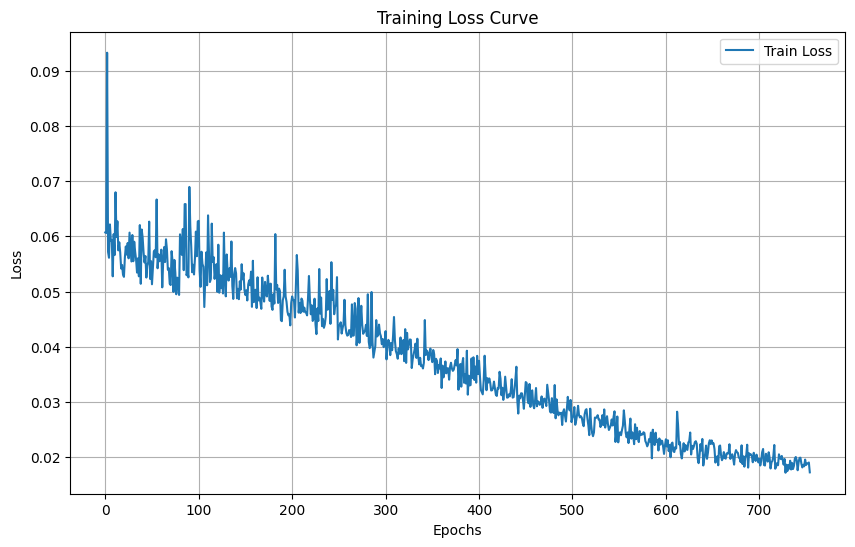

In [14]:
# 9. Plotting Loss Curves
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.plot(train_losses[200:], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend() # Show legend to distinguish between train and val loss
plt.grid(True) # Add grid for easier reading
plt.show()    # Display the plot

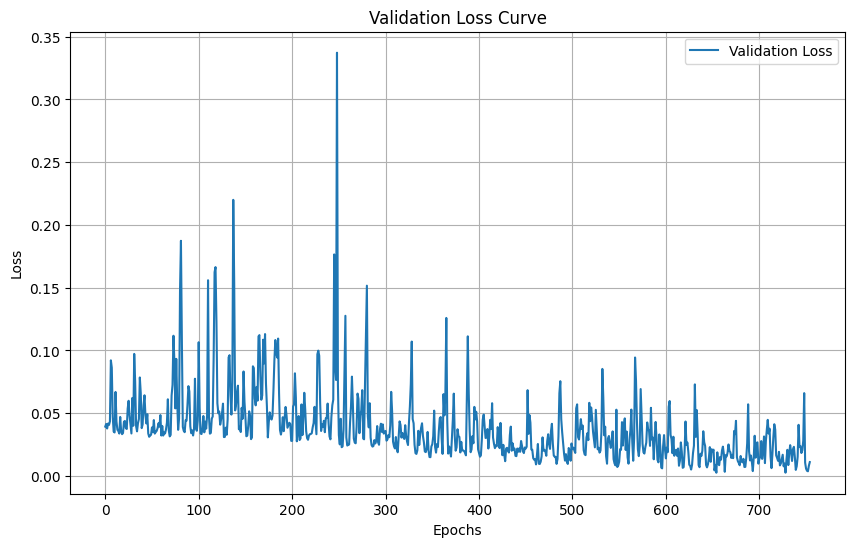

In [15]:
# 9. Plotting Loss Curves
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.plot(val_losses[200:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend() # Show legend to distinguish between train and val loss
plt.grid(True) # Add grid for easier reading
plt.show()    # Display the plot

In [16]:
# 6. Example Inference (after training)
#    Load a sample histogram and IRF (e.g., from your validation set or a new measurement)
sample_index = 3 # Example index from validation set
sample_histogram = torch.tensor(histograms_val[sample_index], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
sample_irf = torch.tensor(irfs_val[sample_index], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

trained_model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_optical_properties = trained_model(sample_histogram, sample_irf)

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()
actual_ups = ups_val[sample_index]
actual_ua = ua_val[sample_index]

print(f"Predicted ups: {predicted_ups:.4f}, Actual ups: {actual_ups:.4f}")
print(f"Predicted ua: {predicted_ua:.4f}, Actual ua: {actual_ua:.4f}")

Predicted ups: 1.1670, Actual ups: 1.2685
Predicted ua: 0.0099, Actual ua: 0.0109


Mean error in ups:  11.650340102681039
Mean error in ua:  16.87475671544352


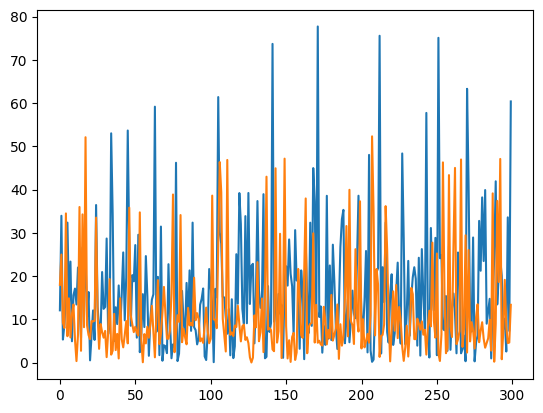

In [17]:
error_ua = []
error_ups = []
actual_uas = []
actual_upss = []

for i in range(len(histograms_val)):
    sample_histogram = torch.tensor(histograms_val[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
    sample_irf = torch.tensor(irfs_val[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

    trained_model.eval() # Set model to evaluation mode
    with torch.no_grad():
        predicted_optical_properties = trained_model(sample_histogram, sample_irf)

    predicted_ups = predicted_optical_properties[0][0].item()
    predicted_ua = predicted_optical_properties[0][1].item()
    actual_ups = ups_val[i]
    actual_ua = ua_val[i]

    actual_uas.append(actual_ua)
    actual_upss.append(actual_ups)

    error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)
    error_ups.append(abs((actual_ups - predicted_ups)/actual_ups)*100)
    

print("Mean error in ups: ", np.mean(error_ups))
print("Mean error in ua: ", np.mean(error_ua))

plt.plot(error_ua, label='Error in ua')
plt.plot(error_ups, label='Error in ups')

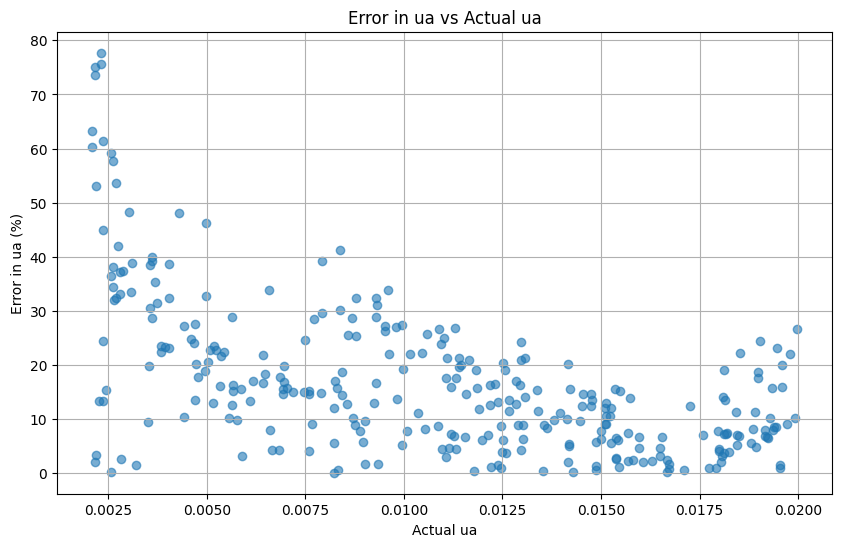

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_uas, error_ua, alpha=0.6)
plt.xlabel('Actual ua')
plt.ylabel('Error in ua (%)')
plt.title('Error in ua vs Actual ua')
plt.grid(True)
plt.show()

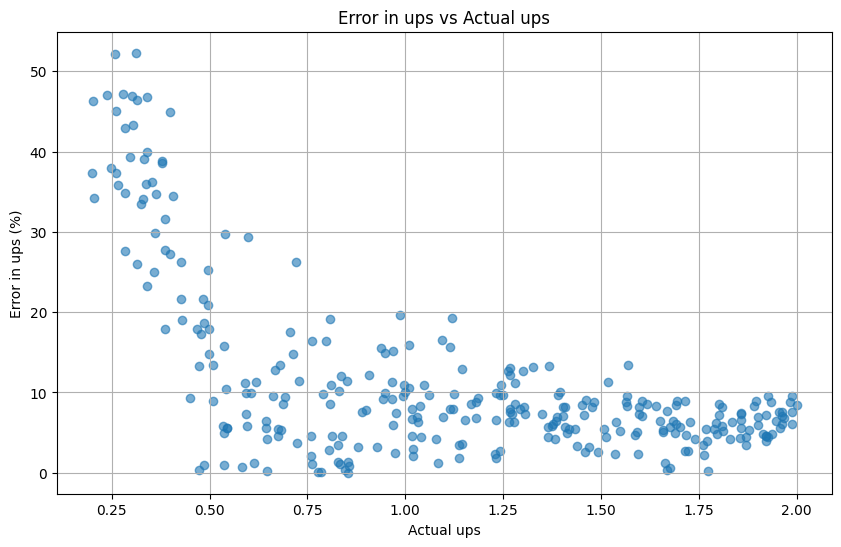

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_upss, error_ups, alpha=0.6)
plt.xlabel('Actual ups')
plt.ylabel('Error in ups (%)')
plt.title('Error in ups vs Actual ups')
plt.grid(True)
plt.show()

In [20]:
# 7. Save the trained model (optional)
torch.save(trained_model.state_dict(), 'optical_properties_estimator.pth')